# Ancilla Evolution - *After the System Thermalizes*

In [1]:
%matplotlib inline
import copy
from qutip import *
import numpy as np
import math, cmath
import matplotlib.pyplot as plt
from tqdm import tqdm

import utilities as use
from stateobj import QState, QAncilla, JointSystem

from IPython.display import Markdown, display

In [2]:
TIMESTEPS = 30000
TIMEDELTA = 1e-02
OMEGA = 10

## Thermal System

$$
\rho^* = \frac{1}{Z}
\begin{pmatrix}
    1 &  &  &  \\
    & \exp\left( \frac{\hbar\omega}{KT} \right) & & \\
    & & \exp\left( 2\frac{\hbar\omega}{KT} \right) & \\
    & & & \ddots \\
    & & & & \exp\left( n\frac{\hbar\omega}{KT} \right) \\
    & & & & & \ddots
\end{pmatrix}
= \frac{1}{Z}
\begin{pmatrix}
    E^0 &  &  &  \\
    & E^1 & & \\
    & & E^2 & \\
    & & & \ddots \\
    & & & & E^n \\
    & & & & & \ddots
\end{pmatrix}
$$

In [3]:
SIM_ID = '4D_T20k_Td02'
system_fresh = JointSystem([use.create_system('fock', n_dims=2, n=0),
                            use.create_system('fock', n_dims=2, n=0)])
system_stable = qload(f'objects/jointss_unitary_{SIM_ID}').history[500]
display(system_fresh)
# The first system stabilizes
display(system_stable[0])
# The second not
display(system_stable[1])
type(system_fresh)

Loaded Qobj object:
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isHerm = True



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.42866034 0.        ]
 [0.         0.57133966]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.48174984 0.        ]
 [0.         0.51825016]]

stateobj.JointSystem

## Ancilla State

In [4]:
alpha = complex(1/math.sqrt(2), 0)
beta = complex(1/math.sqrt(2), 0)
phi = np.pi/3
eta = QAncilla(alpha=alpha, beta=beta, phi=phi)
# Stampa informazioni sull'Ancella
display(eta)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.5  +0.j         0.   +0.j         0.   +0.j        ]
 [0.   +0.j         0.25 +0.j         0.125+0.21650635j]
 [0.   +0.j         0.125-0.21650635j 0.25 +0.j        ]]

## Interaction

In [46]:
ap_int = [tensor(system_fresh.ap[i], qeye(3)) for i in range(len(system_fresh.systems))]
am_int = [tensor(system_fresh.am[i], qeye(3)) for i in range(len(system_fresh.systems))]
# Ladder Operators for the Ancilla
bp_int = tensor(qeye(system_fresh[0].dimentions), qeye(system_fresh[1].dimentions), eta.sigmaminus)
bm_int = tensor(qeye(system_fresh[0].dimentions), qeye(system_fresh[1].dimentions), eta.sigmaplus)
# Interaction 
V = [OMEGA*(ap_int[i]*bp_int + am_int[i]*bm_int) for i in range(len(system_fresh.systems))]
# Unitary Evolution Operator
U = [(-1j*V[i]*TIMEDELTA/2).expm() for i in range(len(system_fresh.systems))]

## Evolve until step N

In [6]:
N = 100
# Systems starts as two Fock states 2D (n=0 and n=1) 
system = copy.deepcopy(system_fresh)
total_system_history = [tensor(system_stable, eta)]
for t in range(N):
    total_system = use.interact(system, eta, V, TIMEDELTA)
    # Trace-off the Ancilla, update the Joint System
    system = JointSystem([total_system.ptrace([0, 1])])
    total_system_history.append(total_system)
display(system)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.34131035+0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.18619855+0.00000000e+00j
  0.16533669-5.42101086e-20j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.16533669+0.00000000e+00j
  0.1533745 +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.3191166 +0.00000000e+00j]]

Now we are here at step N, with S1(N) and S2(N):
![Systems](./img/cascading_systems.png "Systems at step N")

In [7]:
display(system[0])
display(system[1])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.52750891 0.        ]
 [0.         0.47249109]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.49468485 0.        ]
 [0.         0.50531515]]

Step N+1:

Prove that $Tr_{1}\left\{ U_{1,n} (\rho_{n-1}\otimes\eta_n) U_{1,n}^\dagger \right\} = \rho_{n-1}^{S2}\otimes Tr_{1}\left\{ U_{1,n} (\rho_{n-1}^{S1}\otimes\eta_n) U_{1,n}^\dagger \right\}$

So that $\eta'_n = Tr_1\left\{ U_{1,n} (\rho_{n-1}^{S1}\otimes\eta_n) U_{1,n}^\dagger \right\}$ 
and $\eta''_n = Tr_{2}\left\{ U_{2,n} (\rho_{n-1}^{S2}\otimes\eta'_n) U_{2,n}^\dagger \right\}$

We know that $\eta''_n = Tr_{1,2}\left\{ U_{2,n}U_{1,n}(\rho_{n-1}\otimes\eta_n)U_{1,n}^\dagger U_{2,n}^\dagger \right\}$

In [8]:
# 2D Operators (instead of 4D)
v = OMEGA*(tensor(create(2), qeye(3))*tensor(qeye(2), eta.sigmaminus) + tensor(destroy(2), qeye(3))*tensor(qeye(2), eta.sigmaplus))
u = (-1j*v*TIMEDELTA).expm()
eta_second = (U[1]*U[0]*tensor(system, eta)*U[0].dag()*U[1].dag()).ptrace(2)
display(eta_second)
# Hypotesis
eta_prime = (u*tensor(system[0], eta)*u.dag()).ptrace(1)
eta_second = (u*tensor(system[1], eta_prime)*u.dag()).ptrace(1)
display(eta_second)
display(Markdown("***Wrong Hypotesis***"))

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.49635199+0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.251824  +0.j         0.126824  +0.21368858j]
 [0.        +0.j         0.126824  -0.21368858j 0.251824  +0.j        ]]

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.49716498+0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.25141751+0.j         0.12641751+0.21439802j]
 [0.        +0.j         0.12641751-0.21439802j 0.25141751+0.j        ]]

***Wrong Hypotesis***

## Evolution
After one interaction with the Stable System:

In [9]:
total_system = tensor(system_stable, eta)
total_system = U[0]*total_system*U[0].dag()
eta_first = QAncilla(total_system.ptrace(2))
total_system = U[1]*total_system*U[1].dag()
eta_second = QAncilla(total_system.ptrace(2))
display(eta_first)
display(eta_second)
print(f'\t\t\t{"alpha":>16}\t{"beta":>16}\t{"phi":>7}')
print(f'Ancilla (step0):\t{alpha:.5f}\t{beta:.5f}\t{phi:.5f}')
print(f'Ancilla (step1):\t{eta_first.alpha:.5f}\t{eta_first.beta:.5f}\t{eta_first.phi:.5f}')
print(f'Ancilla (step2):\t{eta_second.alpha:.5f}\t{eta_second.beta:.5f}\t{eta_second.phi:.5f}')

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.49999845+0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.25000077+0.j         0.12500077+0.21527142j]
 [0.        +0.j         0.12500077-0.21527142j 0.25000077+0.j        ]]

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.49998113+0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.25000943+0.j         0.12500943+0.21494915j]
 [0.        +0.j         0.12500943-0.21494915j 0.25000943+0.j        ]]

			           alpha	            beta	    phi
Ancilla (step0):	0.70711+0.00000j	0.70711+0.00000j	1.04720
Ancilla (step1):	0.70711+0.00000j	0.70711+0.00000j	1.04720
Ancilla (step2):	0.70709+0.00000j	0.70712+0.00000j	1.04718


In [10]:
stable_temperature = np.zeros((2))
stable_temperature[0] = - system_stable[0].energy / math.log(eta_first.factor)
stable_temperature[1] = - system_stable[0].energy / math.log(eta_second.factor)
stable_temperature

array([-3.47614665, -3.47712362])

After one interaction with the Fresh System:

In [11]:
total_system = tensor(system_fresh, eta)
total_system = U[0]*total_system*U[0].dag()
eta_first = QAncilla(total_system.ptrace(2))
total_system = U[1]*total_system*U[1].dag()
eta_second = QAncilla(total_system.ptrace(2))
display(eta_first)
display(eta_second)
print(f'\t\t\t{"alpha":>16}\t{"beta":>16}\t{"phi":>7}')
print(f'Ancilla (step0):\t{alpha:.5f}\t{beta:.5f}\t{phi:.5f}')
print(f'Ancilla (step1):\t{eta_first.alpha:.5f}\t{eta_first.beta:.5f}\t{eta_first.phi:.5f}')
print(f'Ancilla (step2):\t{eta_second.alpha:.5f}\t{eta_second.beta:.5f}\t{eta_second.phi:.5f}')

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.49006649+0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.25496676+0.j         0.12996676+0.21650635j]
 [0.        +0.j         0.12996676-0.21650635j 0.25496676+0.j        ]]

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.48033033+0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.25983484+0.j         0.13483484+0.21650635j]
 [0.        +0.j         0.13483484-0.21650635j 0.25983484+0.j        ]]

			           alpha	            beta	    phi
Ancilla (step0):	0.70711+0.00000j	0.70711+0.00000j	1.04720
Ancilla (step1):	0.70005+0.00000j	0.71410+0.00000j	1.03591
Ancilla (step2):	0.69306+0.00000j	0.72088+0.00000j	1.02520


In [12]:
stable_temperature = np.zeros((2))
stable_temperature[0] = - system_fresh[0].energy / math.log(eta_first.factor)
stable_temperature[1] = - system_fresh[0].energy / math.log(eta_second.factor)
stable_temperature

array([-4.14129342, -5.09100407])

Do we obtain the same final Ancilla as from the Unitary evolution expression?

*Stable System*

In [13]:
total_system = tensor(system_stable, eta)
total_system = U[1]*U[0]*total_system*U[0].dag()*U[1].dag()
eta_new = QAncilla(total_system.ptrace(2))
display(eta_new)
stable_temperature = - system_stable[0].energy / math.log(eta_new.factor)
stable_temperature

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.49998113+0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.25000943+0.j         0.12500943+0.21494915j]
 [0.        +0.j         0.12500943-0.21494915j 0.25000943+0.j        ]]

-3.4771236171950806

*Fresh System*

In [14]:
total_system = tensor(system_fresh, eta)
total_system = U[1]*U[0]*total_system*U[0].dag()*U[1].dag()
eta_new = QAncilla(total_system.ptrace(2))
display(eta_new)
stable_temperature = - system_fresh[0].energy / math.log(eta_new.factor)
stable_temperature

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.48033033+0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.25983484+0.j         0.13483484+0.21650635j]
 [0.        +0.j         0.13483484-0.21650635j 0.25983484+0.j        ]]

-5.091004067349941

## Taking tracks of the states of the ancilla
$\eta$, $\eta'_n$ and $\eta''_n$ changes at every $n$

In [31]:
# To collect eta, eta' and eta''
eta_history = []
system = copy.deepcopy(system_fresh)
for t in tqdm(range(TIMESTEPS)):
    total_system = tensor(system, eta)
    # First collision with S1
    total_system = U[0]*total_system*U[0].dag()
    eta_prime = QAncilla(total_system.ptrace(2))
    # Second collision with S2
    total_system = U[1]*total_system*U[1].dag()
    eta_second = QAncilla(total_system.ptrace(2))
    eta_history.append([eta, eta_prime, eta_second])
    system = total_system.ptrace([0, 1])
system = JointSystem([system])
display(system[0].full())
display(system[1].full())

100%|████████████████████████████████████| 30000/30000 [02:08<00:00, 233.25it/s]


array([[0.42857143+0.j, 0.        +0.j],
       [0.        +0.j, 0.57142857+0.j]])

array([[0.42857018+0.j, 0.        +0.j],
       [0.        +0.j, 0.57142982+0.j]])

In [45]:
U[0].full()

array([[ 0.99001666+0.j      ,  0.        +0.j      ,
         0.        +0.j      ,  0.        +0.j      ,
         0.        +0.j      ,  0.        +0.j      ,
         0.        +0.j      ,  0.        -0.099667j,
         0.        -0.099667j,  0.        +0.j      ,
         0.        +0.j      ,  0.        +0.j      ],
       [ 0.        +0.j      ,  1.        +0.j      ,
         0.        +0.j      ,  0.        +0.j      ,
         0.        +0.j      ,  0.        +0.j      ,
         0.        +0.j      ,  0.        +0.j      ,
         0.        +0.j      ,  0.        +0.j      ,
         0.        +0.j      ,  0.        +0.j      ],
       [ 0.        +0.j      ,  0.        +0.j      ,
         1.        +0.j      ,  0.        +0.j      ,
         0.        +0.j      ,  0.        +0.j      ,
         0.        +0.j      ,  0.        +0.j      ,
         0.        +0.j      ,  0.        +0.j      ,
         0.        +0.j      ,  0.        +0.j      ],
       [ 0.        +0.j  

In [37]:
display(system)
display(system[0].full())
display(system[1].full())
display(eta.full())
display(eta_history[-1][1].full())

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1.83675071e-01+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 2.44896357e-01+0.00000000e+00j
  4.31671174e-06-1.08420217e-19j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 4.31671174e-06+1.08420217e-19j
  2.44895111e-01+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 3.26533460e-01+0.00000000e+00j]]

array([[0.42857143+0.j, 0.        +0.j],
       [0.        +0.j, 0.57142857+0.j]])

array([[0.42857018+0.j, 0.        +0.j],
       [0.        +0.j, 0.57142982+0.j]])

array([[0.5  +0.j        , 0.   +0.j        , 0.   +0.j        ],
       [0.   +0.j        , 0.25 +0.j        , 0.125+0.21650635j],
       [0.   +0.j        , 0.125-0.21650635j, 0.25 +0.j        ]])

array([[0.5  +0.j        , 0.   +0.j        , 0.   +0.j        ],
       [0.   +0.j        , 0.25 +0.j        , 0.125+0.21527123j],
       [0.   +0.j        , 0.125-0.21527123j, 0.25 +0.j        ]])

### Stable Temperature for the Systems (interacting with $\eta_n$ and $\eta'_n$)

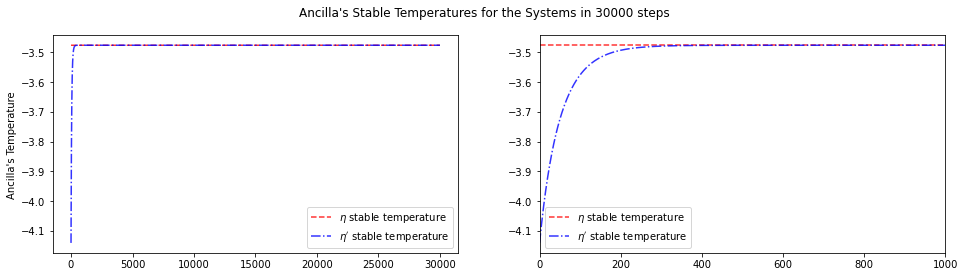

In [16]:
first_stable_temp = [- 1./ math.log(eta[0].factor) for eta in eta_history]
second_stable_temp = [- 1./ math.log(eta[1].factor) for eta in eta_history]
fig, axs = plt.subplots(1, 2, figsize=(16, 4)) 
fig.suptitle(f"Ancilla's Stable Temperatures for the Systems in {TIMESTEPS} steps")
axs[0].plot(first_stable_temp, 'r--', alpha=0.8)
axs[0].plot(second_stable_temp, 'b-.', alpha=0.8)
axs[0].set_ylabel("Ancilla's Temperature")
axs[0].legend(["$\eta$ stable temperature", "$\eta'$ stable temperature"])
axs[1].plot(first_stable_temp, 'r--', alpha=0.8,)
axs[1].plot(second_stable_temp, 'b-.', alpha=0.8)
axs[1].legend(["$\eta$ stable temperature", "$\eta'$ stable temperature"])
axs[1].set_xlim(0, 1000)
plt.show()

### History of Ancillas
They do not interact with stable (Gibbs) Systems

In [32]:
U[0]

Quantum object: dims = [[2, 2, 3], [2, 2, 3]], shape = (12, 12), type = oper, isherm = False
Qobj data =
[[ 0.99001666+0.j        0.        +0.j        0.        +0.j
   0.        +0.j        0.        +0.j        0.        +0.j
   0.        +0.j        0.        -0.099667j  0.        -0.099667j
   0.        +0.j        0.        +0.j        0.        +0.j      ]
 [ 0.        +0.j        1.        +0.j        0.        +0.j
   0.        +0.j        0.        +0.j        0.        +0.j
   0.        +0.j        0.        +0.j        0.        +0.j
   0.        +0.j        0.        +0.j        0.        +0.j      ]
 [ 0.        +0.j        0.        +0.j        1.        +0.j
   0.        +0.j        0.        +0.j        0.        +0.j
   0.        +0.j        0.        +0.j        0.        +0.j
   0.        +0.j        0.        +0.j        0.        +0.j      ]
 [ 0.        +0.j        0.        +0.j        0.        +0.j
   0.99001666+0.j        0.        +0.j        0.        +0.j


In [27]:
display(Markdown("*Ancilla after first interaction at Step 0*"))
display(eta.full())
display(Markdown(f"*Ancilla after first interaction at Step {TIMESTEPS}*"))
display(eta_history[-1][1].full())
display(Markdown("*Ancilla after second interaction at Step 0*"))
display(eta_history[0][2])
display(Markdown(f"*Ancilla after second interaction at Step {TIMESTEPS}*"))
display(eta_history[-1][2])

*Ancilla after first interaction at Step 0*

array([[0.5  +0.j        , 0.   +0.j        , 0.   +0.j        ],
       [0.   +0.j        , 0.25 +0.j        , 0.125+0.21650635j],
       [0.   +0.j        , 0.125-0.21650635j, 0.25 +0.j        ]])

*Ancilla after first interaction at Step 30000*

array([[0.5  +0.j        , 0.   +0.j        , 0.   +0.j        ],
       [0.   +0.j        , 0.25 +0.j        , 0.125+0.21527123j],
       [0.   +0.j        , 0.125-0.21527123j, 0.25 +0.j        ]])

*Ancilla after second interaction at Step 0*

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.48033033+0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.25983484+0.j         0.13483484+0.21650635j]
 [0.        +0.j         0.13483484-0.21650635j 0.25983484+0.j        ]]

*Ancilla after second interaction at Step 30000*

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.5  +0.j         0.   +0.j         0.   +0.j        ]
 [0.   +0.j         0.25 +0.j         0.125+0.21404314j]
 [0.   +0.j         0.125-0.21404314j 0.25 +0.j        ]]

## Theoretical Evolution
$$ \eta' = \eta + \Delta t\left[
   \langle A_+A_- \rangle\left(B_-\eta B_+ -\frac{1}{2}[B_+B_-; \eta]\right) +
   \langle A_-A_+ \rangle\left(B_+\eta B_- -\frac{1}{2}[B_-B_+; \eta]\right)
    \right] 
$$

### *Moments*

In [18]:
print(f"<A+> = {expect(system[0].ap, system[0]).real}")
print(f"<A+> = {expect(system[0].ap, system[0]).real}")

<A+> = 0.0
<A+> = 0.0


In [19]:
first_moments = expect([system[0].ap, system[0].am], system[0])
print(f"First Moments:\t\tComputed\tTheoretical\n"
      f"\tA- :\t\t{first_moments[0].real:.4f}\t\t0\n"
      f"\tA+ :\t\t{first_moments[1].real:.4f}\t\t0\n")
second_moments = expect([system[0].ap*system[0].ap, system[0].am*system[0].am], system[0])
print(f"Second Moments:\t\tComputed\tTheoretical\n"
      f"\tA-A- :\t\t{second_moments[0].real:.4f}\t\t0\n"
      f"\tA+A+ :\t\t{second_moments[1].real:.4f}\t\t0\n")


First Moments:		Computed	Theoretical
	A- :		0.0000		0
	A+ :		0.0000		0

Second Moments:		Computed	Theoretical
	A-A- :		0.0000		0
	A+A+ :		0.0000		0



### *Cross Correlations*
$$\text{Tr}\{a^\dagger a\rho^*\} = \frac{1}{Z}\sum_{n=0}^{\infty} nE^n \equiv \frac{1}{Z}\frac{E}{(1-E)^2}$$
$$\text{Tr}\{a a^\dagger\rho^*\} = \frac{1}{Z}\sum_{n=0}^{\infty} (n+1)E^n \equiv \frac{1}{Z}\frac{E}{(1-E)^2}+1$$

In [20]:
apam = expect(system[0].ap*system[0].am, system[0])
amap = expect(system[0].am*system[0].ap, system[0])
# Sum of infinite series
series = eta.factor/(system[0].partition-eta.factor)**2
# Discrete sum up to n
# number vector
n = np.arange(system[0].dimentions)
disc_sum = np.sum(n * system[0].diag())
disc_sump = np.sum((n+1) * system[0].diag())
print(f"Cross-correlations:\tComputed\tTheoretical\n"
      f"\tA+A- :\t\t{apam:>8.7}\t{disc_sum:>0.7}\n"
      f"\tA-A+ :\t\t{amap:>8.7}\t{disc_sump:>0.7}")

Cross-correlations:	Computed	Theoretical
	A+A- :		0.5714286	0.5714286
	A-A+ :		0.4285714	1.571429


In [21]:
system[0].diag()[1]

0.5714285714268471

In [22]:
eta.factor/system[0].partition

0.5714285714268489

In [23]:
np.sum(np.arange(len(system[0].diag()))*system[0].diag())

0.5714285714268471

In [24]:
first_term = apam*(eta.sigmaminus*eta*eta.sigmaplus-0.5*commutator(eta.sigmaplus*eta.sigmaminus, eta))
second_term = amap*(eta.sigmaplus*eta*eta.sigmaminus-0.5*commutator(eta.sigmaminus*eta.sigmaplus, eta))
eta_new = eta + TIMEDELTA * (first_term + second_term)
eta_new

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.50321429+0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.25285714+0.00092788j 0.12785714+0.21650635j]
 [0.        +0.j         0.12785714-0.21650635j 0.25285714-0.00092788j]]